In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from model import FusionDenoiser

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
torch.manual_seed(43)
np.random.seed(43)

In [5]:
def tens2img(tensor):
    '''Move the axes of a 3D Tensor such that it can be plotted as an image'''
    return np.moveaxis(tensor.detach().cpu().numpy(), 0,-1)

In [6]:
# from https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
import torch, time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {:.3f} GB".format(torch.cuda.max_memory_allocated() / 1024**3))

# Dataset

The class FocalDataset loads grayscale images from a dataset folder.

The parameters 'input_channels' and 'output_channels' control how many times the grayscale values are repeated as extra channels, separately for the model input and model output.

For random data augmentation, effectively increasing our training data, set 'augment' to True. This should be off for validation and test datasets, to ensure consistent evaluation.

The parameter 'normalize' changes the pixel value range from [0,255] to [0,1], which is likely advantageous. As I'm not completely sure though, there's the option to turn it off.

In [7]:
from dataset import FocalDataset

In [8]:
ds = FocalDataset(used_focal_lengths_idx=list(range(8)), augment=True)

In [9]:
stack, gt = ds[0]

In [10]:
stack.shape

torch.Size([8, 1, 512, 512])

In [11]:
gt.shape

torch.Size([1, 512, 512])

Text(0.5, 1.0, 'Ground Truth')

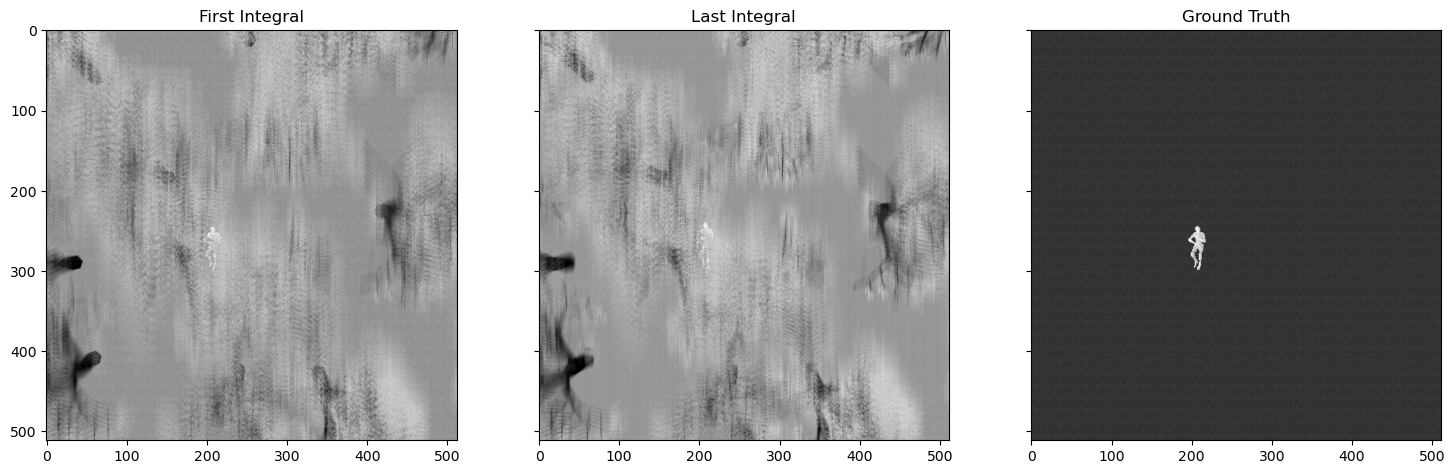

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)

axes[0].imshow(tens2img(stack[0]), cmap='gray')
axes[1].imshow(tens2img(stack[-1]), cmap='gray')
axes[2].imshow(tens2img(gt), cmap='gray')

axes[0].set_title('First Integral')
axes[1].set_title('Last Integral')
axes[2].set_title('Ground Truth')

## DataLoader

The DataLoader wraps around a dataset and gives it additional functionality.

Specifically, it gathers the separate samples provided by the dataset into batches, for more efficient GPU usage.

It also allows for random shuffling of samples, which helps the model to train smoothly. Don't use this for validation/testing though, as we need consistent results.

In [13]:
batch_size = 2
train_dl = torch.utils.data.DataLoader(ds,
                                       batch_size=batch_size,
                                       shuffle=True,     # only for training set!
                                       num_workers=0,    # could be useful to prefetch data while the GPU is working
                                       pin_memory=True)  # should speed up CPU to GPU data transfer

In [14]:
# train_dl would usually be used in a for loop, e.g. "stack, gt in train_dl", but we just get a single sample here for demonstration
stack, gt = next(iter(train_dl))

In [15]:
stack.shape  # batch, n_focal_lengths, channels, dim1, dim2

torch.Size([2, 8, 1, 512, 512])

# Model

There are many different parameters to control the model, many of which are not used here yet but should be played around with.

The one in use here activates the "low V-Ram" execution, decreasing memory usage but increasing training time.

Some things I noticed about the parameter choice:
- larger depth values increase training time
- more heads increase memory usage
- haven't tested deeper network yet (i.e. longer lists for depth and num_heads)
- window size increases memory usage
- mlp_ration increases memory usage

In [16]:
torch.manual_seed(43)
np.random.seed(43)

model = FusionDenoiser(use_checkpoint=True)
model = model.cuda()   # move the model to gpu

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss().cuda()

In [18]:
stack = stack.cuda(non_blocking=True)  # move data to the gpu. non_blocking=True in combination with pin_memory in the dataloader leads to async data transfer, which can speed it up
gt = gt.cuda(non_blocking=True)

## Simple model usage

In [19]:
run_simple = False   # turned off by default, as it is slow and uses a lot of memory, potentially causing a crash

if run_simple:

    for i in range(2):
        start_timer()
        
        fused, denoised = model(stack)   # feed the input to the network
        
        loss = loss_fn(denoised, gt)
        
        loss.backward()   # calculate gradients
        optimizer.step()  # update the weights
        optimizer.zero_grad()   # reset gradients
        
        end_timer_and_print("Default precision:")

## Advanced usage / Automatic mixed precision

Automatic mixed precision (AMP) automatically converts between float16 and float32 values with the goal of increasing calculation speed and decreasing memory usage.

More info [here](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html) and [here](https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-accumulation) (also includes an example with gradient accumulation).

In [20]:
model = FusionDenoiser(use_checkpoint=True).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scaler = torch.cuda.amp.GradScaler()  # used to scale the loss/gradients to prevent float underflow

In [21]:
for i in range(10):  # run multiple times for measuring
    start_timer()
    
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        fused, denoised = model(stack)   # feed the input to the network
    
        loss = loss_fn(denoised, gt)
    
    scaler.scale(loss).backward()  # scale loss and calculate gradients
    scaler.step(optimizer)         # update the weights
    scaler.update()                # update scaling parameters
    optimizer.zero_grad()          # reset gradients
    
    print('\nLoss:',loss)
    
    end_timer_and_print("Mixed precision:")


Loss: tensor(10.3701, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 9.103 sec
Max memory used by tensors = 6.905 GB

Loss: tensor(10.3628, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 5.088 sec
Max memory used by tensors = 6.479 GB

Loss: tensor(10.3542, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 5.091 sec
Max memory used by tensors = 6.479 GB

Loss: tensor(10.3125, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 5.096 sec
Max memory used by tensors = 6.479 GB

Loss: tensor(10.3200, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 5.092 sec
Max memory used by tensors = 6.479 GB

Loss: tensor(10.3406, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed precision:
Total execution time = 5.184 sec
Max memory used by tensors = 6.479 GB

Loss: tensor(4.9106, device='cuda:0', grad_fn=<MeanBackward0>)

Mixed preci

In [22]:
fused.shape   # 'fused' is the result of fusing our image stack into a single image. This output is only useful to sate curiosity of what the model does

torch.Size([2, 1, 512, 512])

In [23]:
denoised.shape  # 'denoised' is the final model prediction. it should be used to calculate metrics and losses

torch.Size([2, 1, 512, 512])

# Plots

Here we plot the first integral of a sample and the corresponding fused and denoised image.

Again, the fused image is just there to get a sense of what the model is doing, the actual output is the denoised image.

Note the colorbars: While both the input stack and ground truth are normalized to [0,1] (if set as such for the dataset), the resulting model output may be quite a bit off from that range, especially at the beginning of training.

Text(0.5, 1.0, 'Ground Truth')

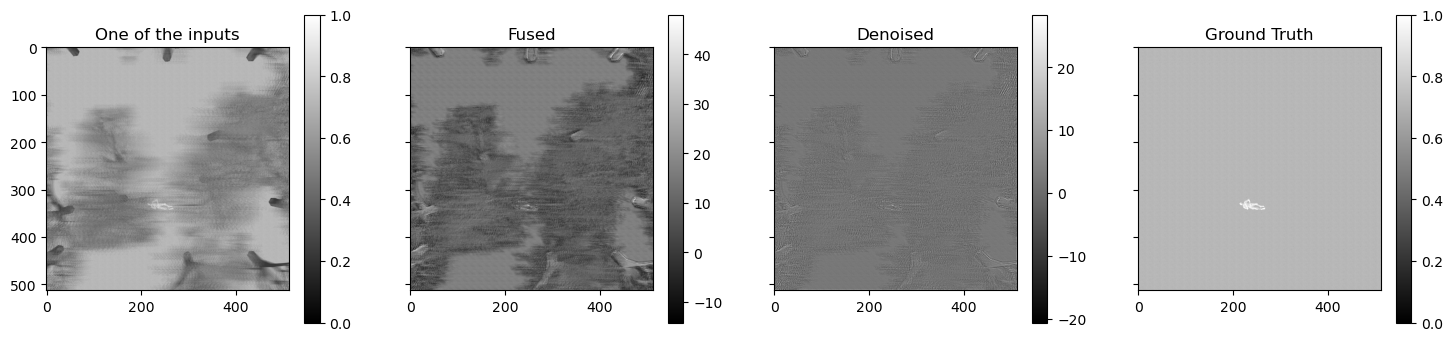

In [24]:
plot_index = 1

fig, axes = plt.subplots(1, 4, figsize=(18,8), sharey=True)

a1 = axes[0].imshow(tens2img(stack[plot_index,0]), cmap='gray', vmin=0, vmax=1)
plt.colorbar(a1, shrink=0.5)
a2 = axes[1].imshow(tens2img(fused[plot_index]), cmap='gray')
plt.colorbar(a2, shrink=0.5)
a3 = axes[2].imshow(tens2img(denoised[plot_index]), cmap='gray')
plt.colorbar(a3, shrink=0.5)
a4 = axes[3].imshow(tens2img(gt[plot_index]), cmap='gray', vmin=0, vmax=1)
plt.colorbar(a4, shrink=0.5)

axes[0].set_title('One of the inputs')
axes[1].set_title('Fused')
axes[2].set_title('Denoised')
axes[3].set_title('Ground Truth')